# Aimsun Microsimulation SQLite Output Database Analyzer


### Goal
This purpose of this Jupyter notebook is to process the database produced by the Aimsun dynamic microsimulation(s).

There are two main objectives for the notebooks:

1. [Check the quality of the simulation](./docs/Analysis_of_Post_Processing.pdf). One of the assessments the post-processing notebooks provides is to produce biplots which compare the simulation data with the ground-truth data. Along with visual graphs, the notebooks also provide the R-square, slope, and intercept values of the biplots. Using these biplots and values, we can determine how fit our current model is to the ideal, or real-world model. For macrosimulation, the compared value is the flow on each detector. For microsimulation, there are three values for comparison: flow, speed, and travel time.

2. Produce data of traffic simulation to better understand traffic inside Fremont. Along with the comparison biplots mentioned above, the notebooks also provide comparison between simulation data and real-world data by each detector. This provides a more detailed view of what is happening during the simulation, and also makes finding the space for improvements easier. On the other hand, when the current model is well calibrated, these output biplots may also help us understand the traffic condition within Fremont in a better manner.
***

**Work done by the code:**

0. [Import Modules](#import)
1. [Microsimulation configuration](#config)
2. [Run Aimsun](#aimsun)
3. [Validation of system-wide metrics](#system-wide-validation)
4. [Validation of specific location metrics](#specific-location-validation)

<a id='import'></a>
# 0. Import modules

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

import postprocessing_util
import postprocessing_plot_util
import simulation_config_utils

module_path = os.path.abspath(os.path.join('..', 'utils'))
if module_path not in sys.path:
    sys.path.append(module_path)
import aimsun_config_utils
import aimsun_folder_utils
import aimsun_input_utils
import metadata_settings

In [2]:
# Get time intervals of study.
TIME_INTERVALS = metadata_settings.get_time_intervals()
TIME_INTERVALS_STRING = [str(time)[:-3] for time in TIME_INTERVALS]

<a id='config'></a>
# 1. Configure microsimulations
Parameters for a single Microscenario:
- From AimsunObject
    - name: A user-generated name for the object.
    - external_id: A user-generated ID for the object.
- From AimsunGenericScenario
    - begin_date: The start date (date time) of the experiment.
    - database_info: A Python AimsunDataBaseInfo object that holds the data needed to link this scenario to an external database.
    - experiment: A Python AimsunGenericExperiment object that holds the data for creating an experiment within Aimsun.
    - master_control_plan_external_id: The External ID of a GKMasterControlPlan Aimsun object.
    - real_dataset_external_id: The External ID of a GKRealDataSet Aimsun object.
    - traffic_demand_external_id: The External ID of a GKTrafficDemand Aimsun object.
    - traffic_strategy_external_ids: A List of External IDs for GKStrategy Aimsun objects.
- From AimsunScenarioInputData
    - detection_interval: The time interval used to gather detection data.
    - global_trajectories_statistics: A boolean denoting whether global trajectory statistics will be saved or not. Global trajectories store origin and destination centroids for each vehicle.
    - section_trajectories_statistics: A boolean denoting whether section trajectory statistics will be saved or not. Section trajectories stores a vehicle's travel data.
    - statistical_interval: The length of the time interval used to gather statistic data.
    - trajectories_statistics: A boolean denoting whether trajectory statistics will be saved or not. Trajectory statistics store every vehicle's current state.
    - trajectory_condition_list: A list of Python AimsunTrajectoryCondition objects (will be updated later upon more research).

Other microscenario parameters are set within the create_simulation_config function. Please check the file simulation_config_utils for more information on how the function sets the parameters, and check the file aimsun_config_utils for more information on each specific parameter.

For more detailed information on the AimsunScenarioInputData parameters, run the help code block below.

In [3]:
help(aimsun_config_utils.AimsunScenarioInputData)

Help on class AimsunScenarioInputData in module aimsun_config_utils:

class AimsunScenarioInputData(builtins.object)
 |  The AimsunScenarioInputData class holds all the scenario input data,
 |  such as traffic demand, control plans, statistics, and public transport
 |  plans. This data will be imported into Aimsun later by accessing its
 |  attributes and assigning them to the relevant attributes within Aimsun.
 |  Python object associated with the Aimsun GKScenarioInputData.
 |  
 |  Attributes:
 |      detection_interval: The time interval used to gather detection data.
 |      global_trajectories_statistics: A boolean denoting whether global
 |          trajectory statistics will be saved or not. Global trajectories
 |          store origin and destination centroids for each vehicle. For public
 |          transport vehicles, the trajectory stores the sections where the
 |          vehicle entered and exited the network. For all vehicles, it stores
 |          the entrance and exit 

## 1.1. Creation of the traffic demand

In [ ]:
TRAFFIC_DEMAND_EXTERNAL_ID = "traffic_demand_afternoon"
aimsun_traffic_demands = simulation_config_utils.create_traffic_demand(TRAFFIC_DEMAND_EXTERNAL_ID)
aimsun_traffic_demands.export_to_file(aimsun_folder_utils.traffic_demand_aimsun_input_file())

## 1.2. Creation of the microsimulation config

In [ ]:
simulation_config_utils.create_microsimulation_config('micro_config', TRAFFIC_DEMAND_EXTERNAL_ID)

<a id='aimsun'></a>
# 2. Run microsimulations inside Aimsun

To run microsimulation inside Aimsun, run in Aimsun the scripts [`create_simulations.py`](../Aimsun/create_simulations.py) and [`run_simulations.py`](../Aimsun/run_simulations.py) both with `MICRO_BASELINE = True`.

Once the simulations are run, you can analyze the results by running the cells below.

In [3]:
# Loading the macrosimulation config. It is assumed that the simulation has been run inside Aimsun.
# We get the simulation data in the database associated to the simulation in the config.
simulation_database_path = aimsun_folder_utils.aimsun_micro_databases_file()
simulation_results_database = postprocessing_util.AimsunMicroOutputDatabase(simulation_database_path)

<a id='system-wide-validation'></a>
# 3. Validation of system-wide metrics

## 3.1 Measure of effectiveness (MOE)

In [8]:
# Select metric to compute.
# Here it is an example of delay time.
metric_name, metric_units = 'average delay time', 's'
simulated_metric_values = postprocessing_plot_util.process_network_delay_time_data(
    simulation_results_database, TIME_INTERVALS)

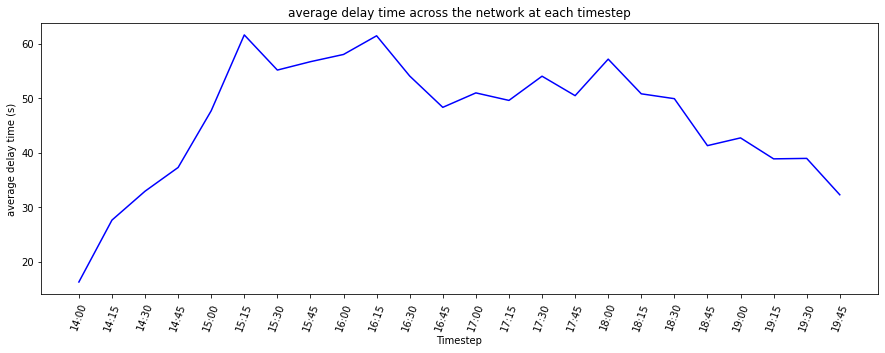

In [10]:
fig = plt.figure(figsize=(15, 5))
plt.title(f"{metric_name} across the network at each timestep")
plt.xlabel("Timestep")
plt.ylabel(f"{metric_name} ({metric_units})")
plt.plot(TIME_INTERVALS_STRING, simulated_metric_values, color='blue')
plt.xticks(rotation=70)
plt.show()

## 3.2 Linear regression plots

In [13]:
# Select metric to compute.
# Here it is an example of flow.
metric_name, metric_units = 'flow', 'veh/hr'

detector_flow_dataset_path = aimsun_folder_utils.detector_flow_aimsun_input_file()
detector_flow_dataset = aimsun_input_utils.AimsunFlowRealDataSet(detector_flow_dataset_path)

real_flow_per_time, real_flow_per_detector, detector_external_id_list = postprocessing_plot_util.process_real_flow_data(
    detector_flow_dataset, TIME_INTERVALS)
simulated_flow_per_time, simulated_flow_per_detector = postprocessing_plot_util.process_micro_simulated_flow_data(
    simulation_results_database, TIME_INTERVALS, detector_external_id_list)

In [14]:
# Global settings for linear regression plot.

# Select whether the intercept should be set to 0.
enforce_intercept = False
# Set lower and upper slope bounds for analysis.
lb_slope, ub_slope = 0.8, 1.2

### 3.2.1 Linear regression plot for selected timesteps

In [15]:
# Select whether graphs should be shown for all timesteps or only for a few.
# If you want all graphs, change the first parameter to False. The second parameter doesn't matter.
# If you want graphs for select timesteps, set the first parameter to True and indicate the second parameter to the
# times of the graph you want to see. (Must be datetime.time objects).
time_steps_to_show = (True, [datetime.time(14, 0), datetime.time(19, 0)])

selected_times = time_steps_to_show[1]
if time_steps_to_show[0] == False:
    selected_times = TIME_INTERVALS

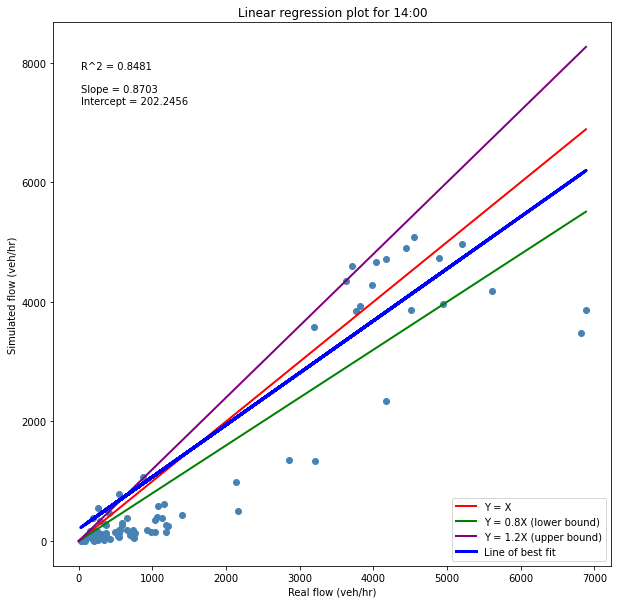

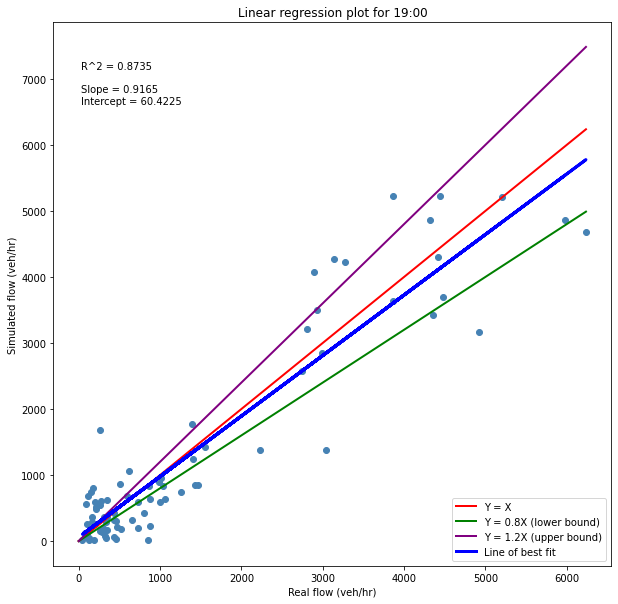

In [16]:
r_sq_all_times_list, slope_all_times_list, intercept_all_times_list = [], [], []

for time in TIME_INTERVALS:
    # Convert flow data to scipy and matplotlib friendly form.
    real_flow_list, simulated_flow_list = postprocessing_plot_util.convert_flow_per_time_to_list(
        real_flow_per_time, simulated_flow_per_time, [time])
    
    # Get regression coefficients.
    slope, intercept, r_sq, max_val, yhat = postprocessing_plot_util.get_linear_regression(
        real_flow_list, simulated_flow_list, enforce_intercept)
    
    r_sq_all_times_list.append(r_sq)
    slope_all_times_list.append(slope)
    intercept_all_times_list.append(intercept)
    
    # Plot flow biplot.
    if time in selected_times:
        fig = plt.figure(figsize=(10, 10))
        plt.title(f"Linear regression plot for {str(time)[:-3]}")
        plt.xlabel(f"Real {metric_name} ({metric_units})")
        plt.ylabel(f"Simulated {metric_name} ({metric_units})")
        plt.scatter(real_flow_list, simulated_flow_list, color='steelblue')
        plt.plot([0, max_val], [0, max_val], color='red', linewidth=2, label='Y = X')
        plt.plot([0, max_val], [0, (lb_slope * max_val)], color='green',
                 linewidth=2, label=f'Y = {lb_slope}X (lower bound)')
        plt.plot([0, max_val], [0, (ub_slope * max_val)], color='purple',
                 linewidth=2, label=f'Y = {ub_slope}X (upper bound)')
        plt.plot(real_flow_list, yhat, color='blue', linewidth=3,
                 label=f'Line of best fit')
        data_summary = f'R^2 = {round(r_sq, 4)} \n\nSlope = {round(slope, 4)} \
                         \nIntercept = {round(intercept, 4)}'
        plt.annotate(data_summary, xy=(0.05, 0.85), xycoords='axes fraction')
        plt.legend(loc="lower right")
        plt.show()

In [17]:
# Summary of Biplots at every timestep
print("Summary of Linear Regressions at every timestep")
print("------------------------------------")
print(f"Averages")
print(f"R^2 = {np.mean(r_sq_all_times_list)}")
print(f"Slope = {np.mean(slope_all_times_list)}")
print(f"Intercept = {np.mean(intercept_all_times_list)}")
print("------------------------------------")
print(f"Standard Deviations")
print(f"R^2 = {np.std(r_sq_all_times_list)}")
print(f"Slope = {np.std(slope_all_times_list)}")
print(f"Intercept = {np.std(intercept_all_times_list)}")
print("------------------------------------")
print(f"Bounds (Min, Max)")
print(f"R^2 = ({min(r_sq_all_times_list)}, {max(r_sq_all_times_list)})")
print(f"Slope = ({min(slope_all_times_list)}, {max(slope_all_times_list)})")
print(f"Intercept = ({min(intercept_all_times_list)}, {max(intercept_all_times_list)})")

Summary of Linear Regressions at every timestep
------------------------------------
Averages
R^2 = 0.851417762618413
Slope = 0.977912760274299
Intercept = 88.88047288228472
------------------------------------
Standard Deviations
R^2 = 0.026324435370627158
Slope = 0.04985597414500693
Intercept = 57.902031595742315
------------------------------------
Bounds (Min, Max)
R^2 = (0.7832020363051184, 0.9018337704606305)
Slope = (0.8703335078971379, 1.0540813408221306)
Intercept = (8.689593272777302, 202.24561463351506)


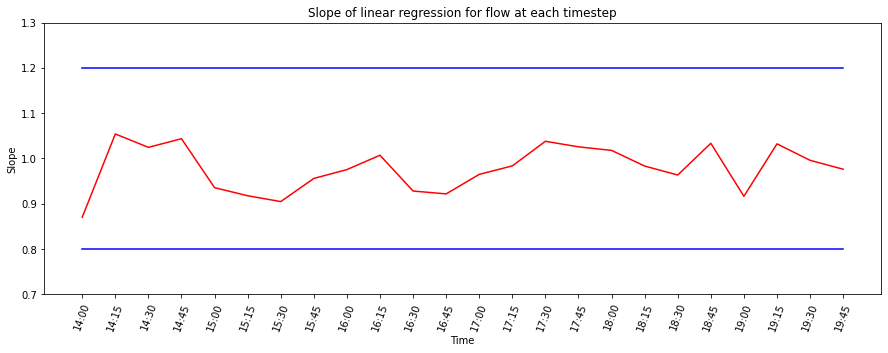

In [18]:
fig = plt.figure(figsize=(15, 5))
plt.xlabel("Time")
plt.ylabel("Slope")

# Change lines below to plot R^2, slope, or intercept.
plt.title(f"Slope of linear regression for flow at each timestep")
plt.plot(TIME_INTERVALS_STRING, slope_all_times_list, color='red', label='Slope')

plt.plot(TIME_INTERVALS_STRING, [lb_slope for _ in TIME_INTERVALS_STRING], color='blue', label='Slope Bounds')
plt.plot(TIME_INTERVALS_STRING, [ub_slope for _ in TIME_INTERVALS_STRING], color='blue')
plt.ylim([0.7, 1.3])
plt.xticks(rotation=70)
plt.show()

### 3.2.2 Linear regression plot for all timesteps

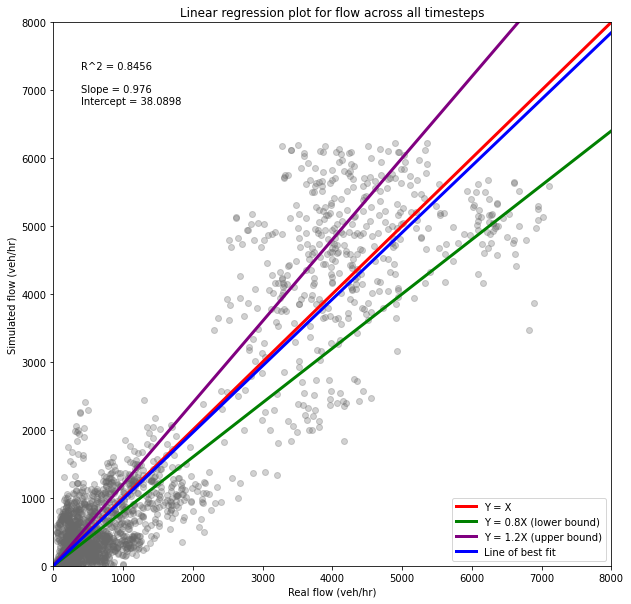

In [19]:
# Convert flow data to scipy and matplotlib friendly form.
all_real_flow_list, all_simulated_flow_list = postprocessing_plot_util.convert_flow_per_time_to_list(
    real_flow_per_time, simulated_flow_per_time, TIME_INTERVALS)

# Get regression coefficients.
slope, intercept, r_sq, max_val, yhat = postprocessing_plot_util.get_linear_regression(
    all_real_flow_list, all_simulated_flow_list, enforce_intercept)

# Plot flow biplot.
fig = plt.figure(figsize=(10, 10))
plt.title(f"Linear regression plot for {metric_name} across all timesteps")
plt.xlabel(f"Real {metric_name} ({metric_units})")
plt.ylabel(f"Simulated {metric_name} ({metric_units})")
plt.scatter(all_real_flow_list, all_simulated_flow_list, color='dimgrey', alpha=0.3)
plt.plot([0, 8000], [0, 8000], color='red', linewidth=3, label='Y = X')
plt.plot([0, 8000], [0, 6400], color='green',
         linewidth=3, label=f'Y = {lb_slope}X (lower bound)')
plt.plot([0, max_val], [0, (ub_slope * max_val)], color='purple',
         linewidth=3, label=f'Y = {ub_slope}X (upper bound)')
plt.plot([0, 8000], [0, 8000 * slope + intercept], color='blue', linewidth=3,
         label=f'Line of best fit')
data_summary = f'R^2 = {round(r_sq, 4)} \n\nSlope = {round(slope, 4)} \
                 \nIntercept = {round(intercept, 4)}'
plt.annotate(data_summary, xy=(0.05, 0.85), xycoords='axes fraction')
plt.xticks([1000 * x for x in range(9)])
plt.yticks([1000 * x for x in range(9)])
plt.xlim([0, 8000])
plt.ylim([0, 8000])
plt.legend(loc="lower right")
plt.show()

<a id='specific-location-validation'></a>
# 4. Validation of specific location metrics

## 4.1 Time-series of detector metrics

In [21]:
# Select metric to compute.
# Here it is an example of flow.
metric_name, metric_units = 'flow', 'veh/hr'

detector_flow_dataset_path = aimsun_folder_utils.detector_flow_aimsun_input_file()
detector_flow_dataset = aimsun_input_utils.AimsunFlowRealDataSet(detector_flow_dataset_path)

real_flow_per_time, real_flow_per_detector, detector_external_id_list = postprocessing_plot_util.process_real_flow_data(
    detector_flow_dataset, TIME_INTERVALS)
simulated_flow_per_time, simulated_flow_per_detector = postprocessing_plot_util.process_micro_simulated_flow_data(
    simulation_results_database, TIME_INTERVALS, detector_external_id_list)

In [22]:
# Choose whether to view all or select detectors
# If the first parameter is set to False, then all detectors are shown regardless of the second parameter.
# If the first parameter is set to True, then only the detectors selected in the second parameter are shown.
flow_profile_settings = (True, ['402798', '402793'])

detectors_to_view = []
if flow_profile_settings[0] == False:
    detectors_to_view = detector_external_id_list
else:
    for detector_identification_code in flow_profile_settings[1]:
        for detector_external_id in detector_external_id_list:
            if detector_identification_code in detector_external_id:
                detectors_to_view.append(detector_external_id)

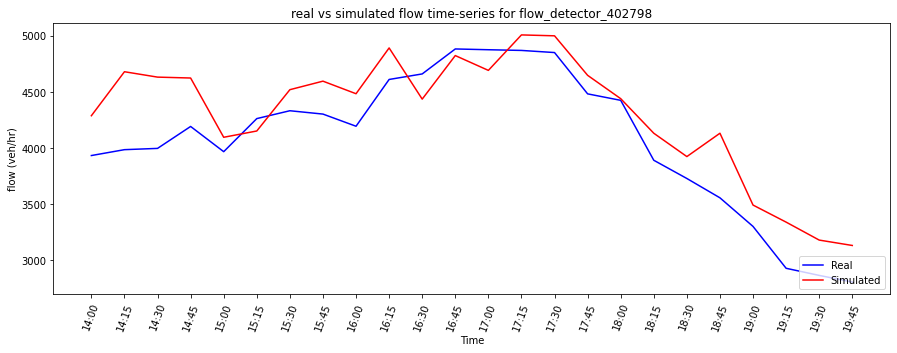

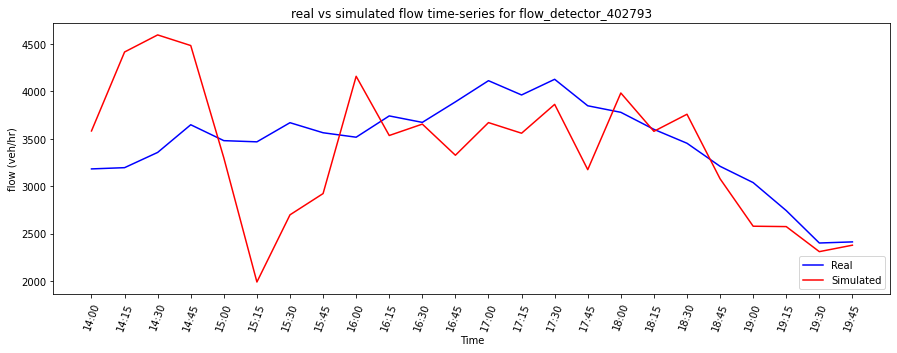

In [23]:
for detector_external_id in detectors_to_view:
    # Get flow profile per detector.
    real_detector_flow_list = []
    simulated_detector_flow_list = []
    for time in TIME_INTERVALS:
        real_detector_flow_list.append(real_flow_per_detector[detector_external_id][time])
        simulated_detector_flow_list.append(simulated_flow_per_detector[detector_external_id][time])
    
    # Draw flow profile.
    fig = plt.figure(figsize=(15, 5))
    plt.title(f"real vs simulated {metric_name} time-series for {detector_external_id}")
    plt.xlabel("Time")
    plt.ylabel(f"{metric_name} ({metric_units})")
    plt.plot(TIME_INTERVALS_STRING, real_detector_flow_list, color='blue', label='Real')
    plt.plot(TIME_INTERVALS_STRING, simulated_detector_flow_list, color='red', label='Simulated')
    plt.legend(loc="lower right")
    plt.xticks(rotation=70)
    plt.show()

## 4.2 Time-space diagram of corridor

In [25]:
# Select metric to compute.
# Here it is an example of flow.
metric_name, metric_units = 'flow', 'veh/hr'

detector_flow_dataset_path = aimsun_folder_utils.detector_flow_aimsun_input_file()
detector_flow_dataset = aimsun_input_utils.AimsunFlowRealDataSet(detector_flow_dataset_path)

real_flow_per_time, real_flow_per_detector, detector_external_id_list = postprocessing_plot_util.process_real_flow_data(
    detector_flow_dataset, TIME_INTERVALS)
simulated_flow_per_time, simulated_flow_per_detector = postprocessing_plot_util.process_micro_simulated_flow_data(
    simulation_results_database, TIME_INTERVALS, detector_external_id_list)

In [26]:
# Select corridor to analyze.
# Here it is an example of I-680 South Bound in Fremont.

# Key: Detector External ID
# Value: Absolute Postmile
I680_SOUTH_BOUND_DETECTORS = {
    'flow_detector_403251': 11.84,
    'flow_detector_403254': 12.19,
    'flow_detector_400566': 12.39,
    'flow_detector_402793': 13.89,
    'flow_detector_403226': 13.96,
    'flow_detector_414015': 14.28,
    'flow_detector_414016': 14.78,
    'flow_detector_402795': 15.30,
    'flow_detector_402797': 15.87,
    'flow_detector_402798': 16.33
}

detectors_to_plot = I680_SOUTH_BOUND_DETECTORS

In [27]:
time_space_dims = (len(TIME_INTERVALS), len(I680_SOUTH_BOUND_DETECTORS))

timestep_meshgrid = np.zeros(shape=time_space_dims)
postmile_meshgrid = np.zeros(shape=time_space_dims)
real_flow_meshgrid = np.zeros(shape=time_space_dims)
simulated_flow_meshgrid = np.zeros(shape=time_space_dims)

for i, time in enumerate(TIME_INTERVALS):
    for j, detector_ext_id in enumerate(detectors_to_plot.keys()):
        timestep_meshgrid[i][j] = i
        postmile_meshgrid[i][j] = detectors_to_plot[detector_ext_id]
        real_flow_meshgrid[i][j] = real_flow_per_detector[detector_ext_id][time]
        simulated_flow_meshgrid[i][j] = simulated_flow_per_detector[detector_ext_id][time]

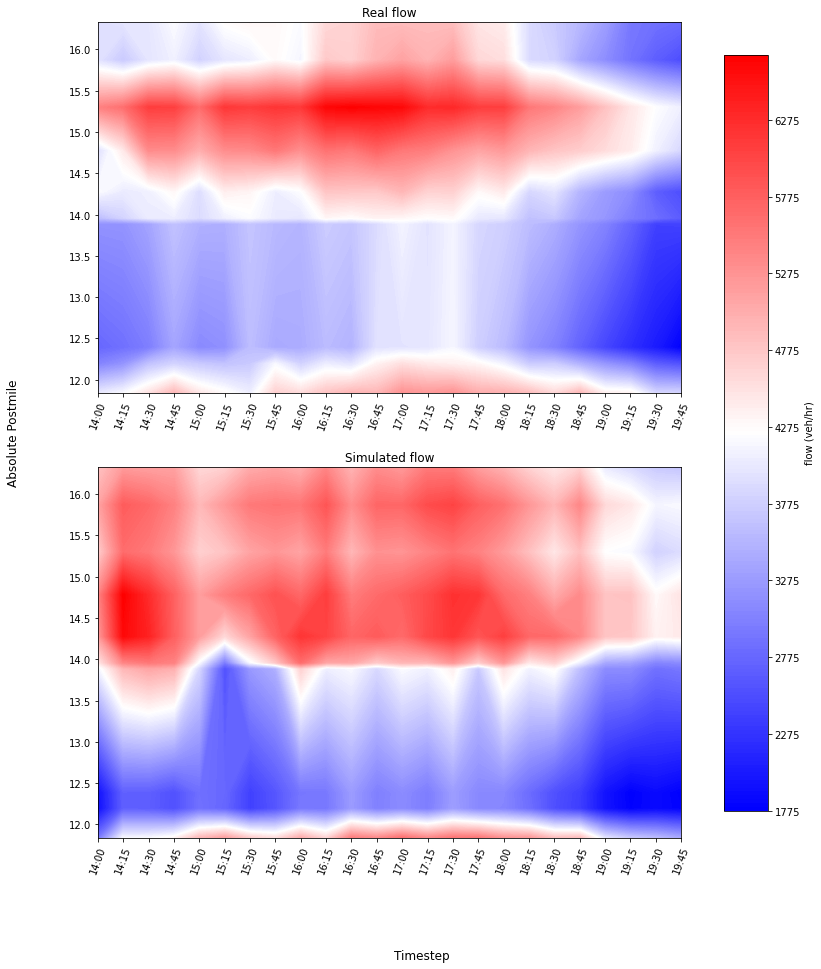

In [29]:
cmap_name = 'bwr'
Q = 200

fig, (ax1, ax2) = plt.subplots(2, sharey=True)
plt.rcParams["figure.figsize"] = (12, 15) 
x_ticks = np.arange(len(TIME_INTERVALS))

ax1.set_title(f'Real {metric_name}')
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(TIME_INTERVALS_STRING, rotation=70)
real_spacetime = ax1.contourf(
    timestep_meshgrid, postmile_meshgrid,
    real_flow_meshgrid, Q, cmap=cmap_name)

ax2.set_title(f'Simulated {metric_name}')
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(TIME_INTERVALS_STRING, rotation=70)
sim_spacetime = ax2.contourf(
    timestep_meshgrid, postmile_meshgrid,
    simulated_flow_meshgrid, Q, cmap=cmap_name)

fig.supxlabel('Timestep')
fig.supylabel("Absolute Postmile")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(real_spacetime, cax=cbar_ax, label=f'{metric_name} ({metric_units})')

plt.show()